<a href="https://colab.research.google.com/github/ashishpatel26/Ganpat-STTP-on-Data-Analytics-with-Python/blob/main/Data_Analysis_with_Python(StackOverFlow_Survey2020).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exploratory Data Analysis using Python - A Case Study

*Analyzing responses from the Stack Overflow Annual Developer Survey 2020*

![](https://i.imgur.com/qXhHKqv.png)

The following topics are covered in this tutorial:

- Selecting and downloading a dataset
- Data preparation and cleaning
- Exploratory analysis and visualization
- Asking and answering interesting questions
- Summarizing inferences and drawing conclusions

## Introduction

In this tutorial, we'll analyze the StackOverflow developer survey dataset. The dataset contains responses to an annual survey conducted by StackOverflow. You can find the raw data & official analysis here: https://insights.stackoverflow.com/survey.

There are several options for getting the dataset into Jupyter:

- Download the CSV manually and upload it via Jupyter's GUI
- Use the `urlretrieve` function from the `urllib.request` to download CSV files from a raw URL
- Use a helper library, e.g., [`opendatasets`](https://github.com/JovianML/opendatasets), which contains a collection of curated datasets and provides a helper function for direct download.

We'll use the `opendatasets` helper library to download the files.

In [2]:
!pip install opendatasets
import opendatasets as od

In [3]:
od.download('stackoverflow-developer-survey-2020')

 85%|████████▍ | 80347136/94603888 [00:01<00:00, 130197686.01it/s]


0it [00:00, ?it/s]
  0%|          | 0/8428 [00:00<?, ?it/s]



0it [00:00, ?it/s]

  0%|          | 0/2268 [00:00<?, ?it/s]

Let's verify that the dataset was downloaded into the directory `stackoverflow-developer-survey-2020` and retrieve the list of files in the dataset.

In [4]:
import os

In [5]:
os.listdir('stackoverflow-developer-survey-2020')

['survey_results_schema.csv', 'README.txt', 'survey_results_public.csv']

You can through the downloaded files using the "File" > "Open" menu option in Jupyter. It seems like the dataset contains three files:

- `README.txt` - Information about the dataset
- `survey_results_schema.csv` - The list of questions, and shortcodes for each question
- `survey_results_public.csv` - The full list of responses to the questions 

Let's load the CSV files using the Pandas library. We'll use the name `survey_raw_df` for the data frame to indicate this is unprocessed data that we might clean, filter, and modify to prepare a data frame ready for analysis.

In [6]:
import pandas as pd

In [7]:
survey_raw_df = pd.read_csv('stackoverflow-developer-survey-2020/survey_results_public.csv')

In [8]:
survey_raw_df

,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,CurrencySymbol,DatabaseDesireNextYear,DatabaseWorkedWith,DevType,EdLevel,Employment,Ethnicity,Gender,JobFactors,JobSat,JobSeek,LanguageDesireNextYear,LanguageWorkedWith,MiscTechDesireNextYear,MiscTechWorkedWith,NEWCollabToolsDesireNextYear,NEWCollabToolsWorkedWith,NEWDevOps,NEWDevOpsImpt,NEWEdImpt,NEWJobHunt,NEWJobHuntResearch,NEWLearn,NEWOffTopic,NEWOnboardGood,NEWOtherComms,NEWOvertime,NEWPurchaseResearch,NEWPurpleLink,NEWSOSites,NEWStuck,OpSys,OrgSize,PlatformDesireNextYear,PlatformWorkedWith,PurchaseWhat,Sexuality,SOAccount,SOComm,SOPartFreq,SOVisitFreq,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,EUR,Microsoft SQL Server,Elasticsearch;Microsoft SQL Server;Oracle,"Developer, desktop or enterprise applications;...","Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Independent contractor, freelancer, or self-em...",White or of European descent,Man,"Languages, frameworks, and other technologies ...",Slightly satisfied,I am not interested in new job opportunities,C#;HTML/CSS;JavaScript,C#;HTML/CSS;JavaScript,.NET Core;Xamarin,.NET;.NET Core,Microsoft Teams;Microsoft Azure;Trello,Confluence;Jira;Slack;Microsoft Azure;Trello,No,Somewhat important,Fairly important,NaN,NaN,Once a year,Not sure,NaN,No,Often: 1-2 days per week or more,Start a free trial;Ask developers I know/work ...,Amused,Stack Overflow (public Q&A for anyone who codes),Visit Stack Overflow;Go for a walk or other ph...,Windows,2 to 9 employees,Android;iOS;Kubernetes;Microsoft Azure;Windows,Windows,NaN,Straight / Heterosexual,No,"No, not at all",NaN,Multiple times per day,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,GBP,NaN,NaN,"Developer, full-stack;Developer, mobile","Bachelor’s degree (B.A., B.S., B.Eng., etc.)",Employed full-time,NaN,NaN,NaN,Very dissatisfied,I am not interested in new job opportunities,Python;Swift,JavaScript;Swift,React Native;TensorFlow;Unity 3D,React Native,Github;Slack,Confluence;Jira;Github;Gitlab;Slack,NaN,NaN,Fairly important,NaN,NaN,Once a year,Not sure,NaN,No,NaN,NaN,Amused,Stack Overflow (public Q&A for anyone who code...,Visit Stack Overflow;Go for a walk or other ph...,MacOS,"1,000 to 4,999 employees",iOS;Kubernetes;Linux;MacOS,iOS,I have little or no influence,NaN,Yes,"Yes, definitely",Less than once per month or monthly,Multiple times per day,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Objective-C;Python;Swift,Objective-C;Python;Swift,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Once a decade,NaN,NaN,No,NaN,NaN,NaN,Stack Overflow (public Q&A for anyone who codes),NaN,Linux-based,NaN,NaN,NaN,NaN,NaN,Yes,"Yes, somewhat",A few times per month or weekly,Daily or almost daily,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,ALL,NaN,NaN,NaN,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)",NaN,White or of European descent,Man,Flex time or a flexible schedule;Office enviro...,Slightly dissatisfied,"I’m not actively looking, but I am open to new...",NaN,NaN,NaN,NaN,NaN,NaN,No,NaN,Not at all important/not necessary,Curious about other opportunities;Wanting to w...,NaN,Once a year,Not sure,Yes,Yes,Occasionally: 1-2 days per quarter but less th...,NaN,NaN,Stack Overflow (public Q&A for anyone who code...,NaN,Lin

The dataset contains over 64,000 responses to 60 questions (although many questions are optional). The responses have been anonymized to remove personally identifiable information, and each respondent has been assigned a randomized respondent ID.

Let's view the list of columns in the data frame. 

In [9]:
survey_raw_df.columns

Index(['Respondent', 'MainBranch', 'Hobbyist', 'Age', 'Age1stCode', 'CompFreq',
       'CompTotal', 'ConvertedComp', 'Country', 'CurrencyDesc',
       'CurrencySymbol', 'DatabaseDesireNextYear', 'DatabaseWorkedWith',
       'DevType', 'EdLevel', 'Employment', 'Ethnicity', 'Gender', 'JobFactors',
       'JobSat', 'JobSeek', 'LanguageDesireNextYear', 'LanguageWorkedWith',
       'MiscTechDesireNextYear', 'MiscTechWorkedWith',
       'NEWCollabToolsDesireNextYear', 'NEWCollabToolsWorkedWith', 'NEWDevOps',
       'NEWDevOpsImpt', 'NEWEdImpt', 'NEWJobHunt', 'NEWJobHuntResearch',
       'NEWLearn', 'NEWOffTopic', 'NEWOnboardGood', 'NEWOtherComms',
       'NEWOvertime', 'NEWPurchaseResearch', 'NEWPurpleLink', 'NEWSOSites',
       'NEWStuck', 'OpSys', 'OrgSize', 'PlatformDesireNextYear',
       'PlatformWorkedWith', 'PurchaseWhat', 'Sexuality', 'SOAccount',
       'SOComm', 'SOPartFreq', 'SOVisitFreq', 'SurveyEase', 'SurveyLength',
       'Trans', 'UndergradMajor', 'WebframeDesireNextYear',
  

It appears that shortcodes for questions have been used as column names. 

We can refer to the schema file to see the full text of each question. The schema file contains only two columns: `Column` and `QuestionText`. We can load it as Pandas Series with `Column` as the index and the  `QuestionText` as the value.

In [10]:
schema_fname = 'stackoverflow-developer-survey-2020/survey_results_schema.csv'
schema_raw = pd.read_csv(schema_fname, index_col='Column').QuestionText

In [11]:
schema_raw

Column
Respondent            Randomized respondent ID number (not in order ...
MainBranch            Which of the following options best describes ...
Hobbyist                                        Do you code as a hobby?
Age                   What is your age (in years)? If you prefer not...
Age1stCode            At what age did you write your first line of c...
                                            ...                        
WebframeWorkedWith    Which web frameworks have you done extensive d...
WelcomeChange         Compared to last year, how welcome do you feel...
WorkWeekHrs           On average, how many hours per week do you wor...
YearsCode             Including any education, how many years have y...
YearsCodePro          NOT including education, how many years have y...
Name: QuestionText, Length: 61, dtype: object

We can now use `schema_raw` to retrieve the full question text for any column in `survey_raw_df`.

In [12]:
schema_raw['YearsCodePro']

'NOT including education, how many years have you coded professionally (as a part of your work)?'

We've now loaded the dataset. We're ready to move on to the next step of preprocessing & cleaning the data for our analysis.

## Data Preparation & Cleaning

While the survey responses contain a wealth of information, we'll limit our analysis to the following areas:

- Demographics of the survey respondents and the global programming community
- Distribution of programming skills, experience, and preferences
- Employment-related information, preferences, and opinions

Let's select a subset of columns with the relevant data for our analysis.

In [13]:
selected_columns = [
    # Demographics
    'Country',
    'Age',
    'Gender',
    'EdLevel',
    'UndergradMajor',
    # Programming experience
    'Hobbyist',
    'Age1stCode',
    'YearsCode',
    'YearsCodePro',
    'LanguageWorkedWith',
    'LanguageDesireNextYear',
    'NEWLearn',
    'NEWStuck',
    # Employment
    'Employment',
    'DevType',
    'WorkWeekHrs',
    'JobSat',
    'JobFactors',
    'NEWOvertime',
    'NEWEdImpt'
]

In [14]:
len(selected_columns)

20

Let's extract a copy of the data from these columns into a new data frame `survey_df`. We can continue to modify further without affecting the original data frame.

In [15]:
survey_df = survey_raw_df[selected_columns].copy()

In [16]:
schema = schema_raw[selected_columns]

Let's view some basic information about the data frame.

In [17]:
survey_df.shape

(64461, 20)

In [18]:
survey_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64461 entries, 0 to 64460
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Country                 64072 non-null  object 
 1   Age                     45446 non-null  float64
 2   Gender                  50557 non-null  object 
 3   EdLevel                 57431 non-null  object 
 4   UndergradMajor          50995 non-null  object 
 5   Hobbyist                64416 non-null  object 
 6   Age1stCode              57900 non-null  object 
 7   YearsCode               57684 non-null  object 
 8   YearsCodePro            46349 non-null  object 
 9   LanguageWorkedWith      57378 non-null  object 
 10  LanguageDesireNextYear  54113 non-null  object 
 11  NEWLearn                56156 non-null  object 
 12  NEWStuck                54983 non-null  object 
 13  Employment              63854 non-null  object 
 14  DevType                 49370 non-null

Most columns have the data type `object`, either because they contain values of different types or contain empty values (`NaN`). It appears that every column contains some empty values since the Non-Null count for every column is lower than the total number of rows (64461). We'll need to deal with empty values and manually adjust the data type for each column on a case-by-case basis. 

Only two of the columns were detected as numeric columns (`Age` and `WorkWeekHrs`), even though a few other columns have mostly numeric values. To make our analysis easier, let's convert some other columns into numeric data types while ignoring any non-numeric value. The non-numeric are converted to `NaN`.

In [19]:
survey_df['Age1stCode'] = pd.to_numeric(survey_df.Age1stCode, errors='coerce')
survey_df['YearsCode'] = pd.to_numeric(survey_df.YearsCode, errors='coerce')
survey_df['YearsCodePro'] = pd.to_numeric(survey_df.YearsCodePro, errors='coerce')

Let's now view some basic statistics about numeric columns.

In [20]:
survey_df.describe()

,Age,Age1stCode,YearsCode,YearsCodePro,WorkWeekHrs
count,45446.000000,57473.000000,56784.000000,44133.000000,41151.000000
mean,30.834111,15.476572,12.782051,8.869667,40.782174
std,9.585392,5.114081,9.490657,7.759961,17.816383
min,1.000000,5.000000,1.000000,1.000000,1.000000
25%,24.000000,12.000000,6.000000,3.000000,40.000000
50%,29.000000,15.000000,10.000000,6.000000,40.000000
75%,35.000000,18.000000,17.000000,12.000000,44.000000
max,279.000000,85.000000,50.000000,50.000000,475.000000


There seems to be a problem with the age column, as the minimum value is 1 and the maximum is 279. This is a common issue with surveys: responses may contain invalid values due to accidental or intentional errors while responding. A simple fix would be to ignore the rows where the age is higher than 100 years or lower than 10 years as invalid survey responses. We can do this using the `.drop` method, [as explained here](https://www.geeksforgeeks.org/drop-rows-from-the-dataframe-based-on-certain-condition-applied-on-a-column/).

In [21]:
survey_df.drop(survey_df[survey_df.Age < 10].index, inplace=True)
survey_df.drop(survey_df[survey_df.Age > 100].index, inplace=True)

The same holds for `WorkWeekHrs`. Let's ignore entries where the value for the column is higher than 140 hours. (~20 hours per day).

In [22]:
survey_df.drop(survey_df[survey_df.WorkWeekHrs > 140].index, inplace=True)

The gender column also allows for picking multiple options. We'll remove values containing more than one option to simplify our analysis.

In [23]:
survey_df['Gender'].value_counts()

Man                                                            45895
Woman                                                           3835
Non-binary, genderqueer, or gender non-conforming                385
Man;Non-binary, genderqueer, or gender non-conforming            121
Woman;Non-binary, genderqueer, or gender non-conforming           92
Woman;Man                                                         73
Woman;Man;Non-binary, genderqueer, or gender non-conforming       25
Name: Gender, dtype: int64

In [24]:
import numpy as np

In [25]:
survey_df.where(~(survey_df.Gender.str.contains(';', na=False)), np.nan, inplace=True)

We've now cleaned up and prepared the dataset for analysis. Let's take a look at a sample of rows from the data frame.

In [26]:
survey_df.sample(10)

,Country,Age,Gender,EdLevel,UndergradMajor,Hobbyist,Age1stCode,YearsCode,YearsCodePro,LanguageWorkedWith,LanguageDesireNextYear,NEWLearn,NEWStuck,Employment,DevType,WorkWeekHrs,JobSat,JobFactors,NEWOvertime,NEWEdImpt
10020,India,NaN,NaN,NaN,NaN,No,NaN,NaN,NaN,Java;SQL,Dart,Once a year,Visit Stack Overflow;Watch help / tutorial videos,Employed full-time,"Developer, mobile",NaN,NaN,NaN,NaN,NaN
48208,United Kingdom,22.0,Man,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Computer science, computer engineering, or sof...",Yes,15.0,7.0,NaN,Bash/Shell/PowerShell;Go,Go;Kotlin;Scala;TypeScript,Once a year,Visit Stack Overflow;Do other work and come ba...,Student,NaN,NaN,NaN,"Languages, frameworks, and other technologies ...",NaN,NaN
43807,India,NaN,NaN,NaN,NaN,Yes,NaN,NaN,NaN,HTML/CSS;JavaScript;PHP;SQL,JavaScript,Once every few years,NaN,Employed full-time,NaN,NaN,NaN,NaN,NaN,NaN
29878,Russian Federation,28.0,Man,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Information systems, information technology, o...",Yes,16.0,12.0,8.0,HTML/CSS;JavaScript;PHP,HTML/CSS;JavaScript;PHP;Python,Once every few years,Call a coworker or friend;Visit Stack Overflow...,Employed full-time,"Developer, full-stack",42.0,Slightly satisfied,"Languages, frameworks, and other technologies ...",Often: 1-2 days per week or more,Not at all important/not necessary
59184,Hungary,24.0,Man,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Computer science, computer engineering, or sof...",Yes,15.0,5.0,3.0,Bash/Shell/PowerShell;C;C++;HTML/CSS;Java;Java...,Go;HTML/CSS;Java;JavaScript;Python;Rust;SQL;Ty...,Once a year,Call a coworker or friend;Visit Stack Overflow,Employed full-time,"Developer, back-end;Developer, front-end;Devel...",40.0,Very dissatisfied,"Languages, frameworks, and other technologies ...",Often: 1-2 days per week or more,Not at all important/not necessary
45306,Kenya,28.0,Man,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","Computer science, computer engineering, or sof...",Yes,18.0,10.0,7.0,Bash/Shell/PowerShell;C#;JavaScript;SQL;TypeSc...,Bash/Shell/PowerShell;C#;C++;Go;JavaScript;Rus...,Once every few years,Call a coworker or friend;Visit Stack Overflow...,Employed full-time,"Developer, desktop or enterprise applications;...",50.0,Neither satisfied nor dissatisfied,"Industry that I’d be working in;Languages, fra...",Sometimes: 1-2 days per month but less than we...,Critically important
48321,France,26.0,Man,"Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","A business discipline (such as accounting, fin...",Yes,11.0,4.0,NaN,HTML/CSS;JavaScript;Ruby;TypeScript,HTML/CSS;JavaScript;Python;Ruby;Swift;TypeScript,Every few months,Call a coworker or friend;Visit Stack Overflow,Employed full-time,"Developer, front-end",NaN,NaN,Flex time or a flexible schedule;Remote work o...,NaN,NaN
60947,New Zealand,63.0,Man,"Secondary school (e.g. American high school, G...",NaN,No,48.0,21.0,21.0,HTML/CSS;JavaScript;SQL,HTML/CSS;Java;JavaScript;Julia;Python;SQL,Every few months,Go for a walk or other physical activity;Watch...,"Independent contractor, freelancer, or self-em...",Database administrator;Designer,20.0,Very satisfied,Specific department or team I’d be working on;...,Sometimes: 1-2 days per month but less than we...,Not at all important/not necessary
38475,Austria,NaN,NaN,Some college/university study without earning ...,"Computer science, computer engineering, or sof...",No,5.0,5.0,NaN,C#;HTML/CSS;Java;JavaScript;SQL,Python,Once a year,Visit Stack Overflow,Employed full-time,"Developer, back-end",NaN,Neither satisfied nor dissatisfied,NaN,NaN,Somewhat important
19479,United States,35.0,Man,"Bachelor’s degree (B.A., B.S., B.Eng., etc.)","Computer science, computer engineering, or sof...",Yes,8.0,18.0,12.0,C#;HTML/CSS;JavaScript;SQL,C#;HTML/CSS;JavaScript;Kotlin,Once every few years,Visit Stack Overflow;Watch help / tutorial vid...,Employed full-time,"Developer, back-end;Developer, desktop or ente...",45.0,Slightly dissatisfied,"Flex time or a flexible schedu

## Exploratory Analysis and Visualization

Before we ask questions about the survey responses, it would help to understand the respondents' demographics, i.e., country, age, gender, education level, employment level, etc. It's essential to explore these variables to understand how representative the survey is of the worldwide programming community. A survey of this scale generally tends to have some [selection bias](https://en.wikipedia.org/wiki/Selection_bias).

Let's begin by importing `matplotlib.pyplot` and `seaborn`.

In [27]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (9, 5)
matplotlib.rcParams['figure.facecolor'] = '#00000000'

### Country

Let's look at the number of countries from which there are responses in the survey and plot the ten countries with the highest number of responses.

In [28]:
schema.Country

'Where do you live?'

In [29]:
survey_df.Country.nunique()

183

We can identify the countries with the highest number of respondents using the `value_counts` method.

In [30]:
top_countries = survey_df.Country.value_counts().head(15)
top_countries

United States         12371
India                  8364
United Kingdom         3881
Germany                3864
Canada                 2175
France                 1884
Brazil                 1804
Netherlands            1332
Poland                 1259
Australia              1199
Spain                  1157
Italy                  1115
Russian Federation     1085
Sweden                  879
Pakistan                802
Name: Country, dtype: int64

We can visualize this information using a bar chart.

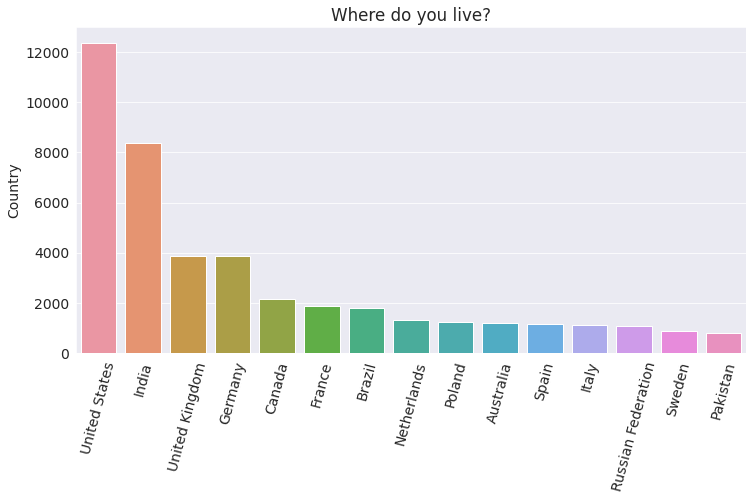

In [31]:
plt.figure(figsize=(12,6))
plt.xticks(rotation=75)
plt.title(schema.Country)
sns.barplot(x=top_countries.index, y=top_countries);

It appears that a disproportionately high number of respondents are from the US and India, probably because the survey is in English, and these countries have the highest English-speaking populations. We can already see that the survey may not be representative of the global programming community - especially from non-English speaking countries. Programmers from non-English speaking countries are almost certainly underrepresented.

**Exercise**:
Try finding the percentage of responses from English-speaking vs. non-English speaking countries. You can use [this list of languages spoken in different countries](https://github.com/JovianML/opendatasets/blob/master/data/countries-languages-spoken/countries-languages.csv).

### Age

The distribution of respondents' age is another crucial factor to look at. We can use a histogram to visualize it. 

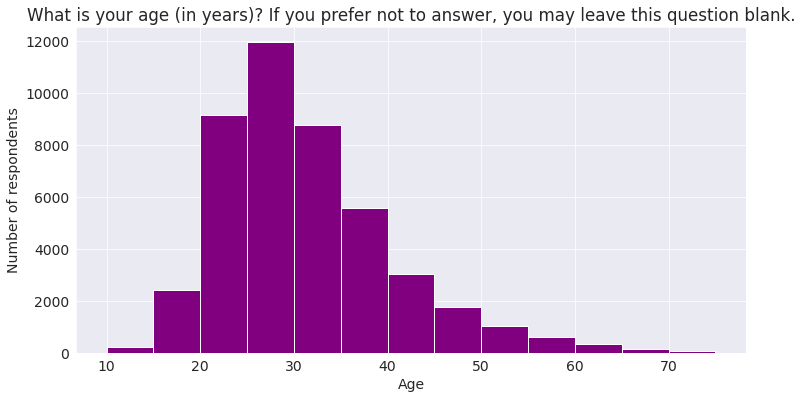

In [32]:
plt.figure(figsize=(12, 6))
plt.title(schema.Age)
plt.xlabel('Age')
plt.ylabel('Number of respondents')

plt.hist(survey_df.Age, bins=np.arange(10,80,5), color='purple');

It appears that a large percentage of respondents are 20-45 years old. It's somewhat representative of the programming community in general. Many young people have taken up computer science as their field of study or profession in the last 20 years.

**Exercise**: You may want to filter out responses by age (or age group) if you'd like to analyze and compare the survey results for different age groups. Create a new column called AgeGroup containing values like `Less than 10 years`, `10-18 years`, `18-30 years`, `30-45 years`, `45-60 years` and `Older than 60 years`. Then, repeat the analysis in the rest of this notebook for each age group.


### Gender

Let's look at the distribution of responses for the Gender. It's a well-known fact that women and non-binary genders are underrepresented in the programming community, so we might expect to see a skewed distribution here.

In [33]:
schema.Gender

'Which of the following describe you, if any? Please check all that apply. If you prefer not to answer, you may leave this question blank.'

In [34]:
gender_counts = survey_df.Gender.value_counts()
gender_counts

Man                                                  45895
Woman                                                 3835
Non-binary, genderqueer, or gender non-conforming      385
Name: Gender, dtype: int64

A pie chart would be a great way to visualize the distribution.

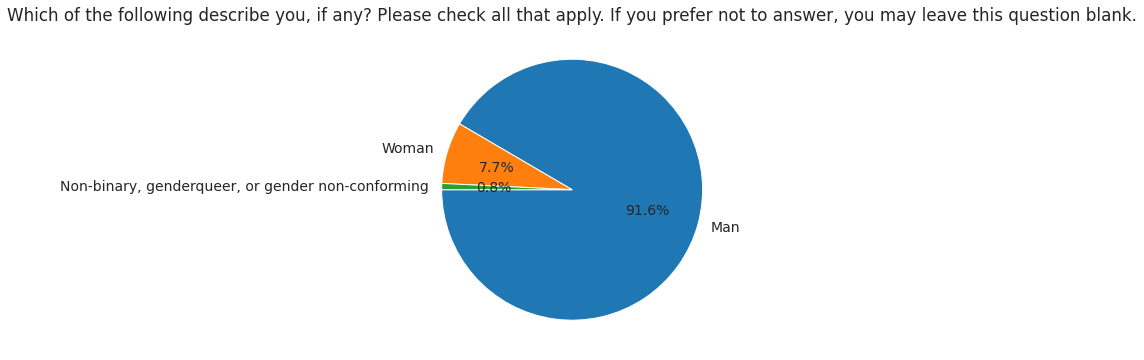

In [35]:
plt.figure(figsize=(12,6))
plt.title(schema.Gender)
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=180);

Only about 8% of survey respondents who have answered the question identify as women or non-binary. This number is lower than the overall percentage of women & non-binary genders in the programming community - which is estimated to be around 12%. 

**Exercise**: It would be interesting to compare the survey responses & preferences across genders. Repeat this analysis with these breakdowns. How do the relative education levels differ across genders? How do the salaries vary? You may find this analysis on the [Gender Divide in Data Science](https://medium.com/datadriveninvestor/exploratory-data-analysis-eda-understanding-the-gender-divide-in-data-science-roles-9faa5da44f5b) useful.

### Education Level

Formal education in computer science is often considered an essential requirement for becoming a programmer. However, there are many free resources & tutorials available online to learn programming. Let's compare the education levels of respondents to gain some insight into this. We'll use a horizontal bar plot here.

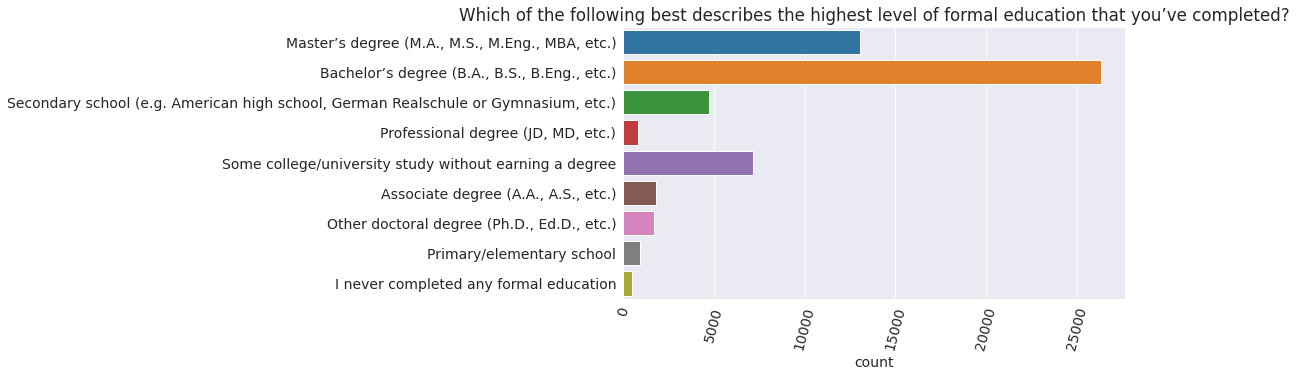

In [36]:
sns.countplot(y=survey_df.EdLevel)
plt.xticks(rotation=75);
plt.title(schema['EdLevel'])
plt.ylabel(None);

It appears that well over half of the respondents hold a bachelor's or master's degree, so most programmers seem to have some college education. However, it's not clear from this graph alone if they hold a degree in computer science.

**Exercises**: The graph currently shows the number of respondents for each option. Can you modify it to show the percentage instead? Further, try comparing the percentages for each degree for men vs. women. 

Let's also plot undergraduate majors, but this time we'll convert the numbers into percentages and sort the values to make it easier to visualize the order.

In [37]:
schema.UndergradMajor

'What was your primary field of study?'

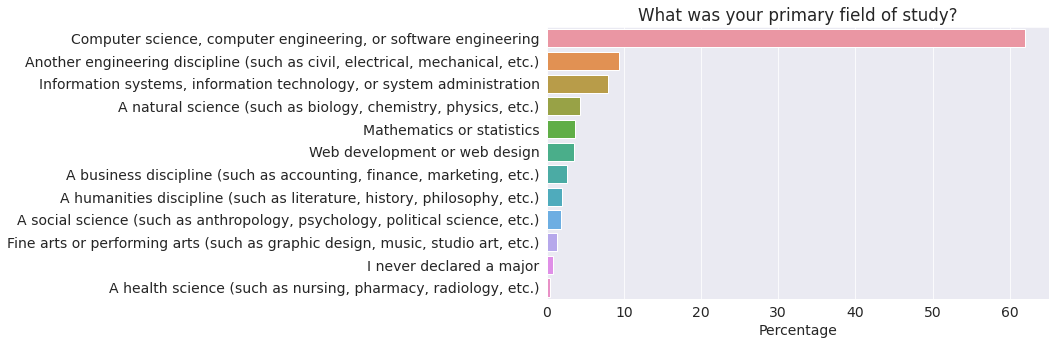

In [38]:
undergrad_pct = survey_df.UndergradMajor.value_counts() * 100 / survey_df.UndergradMajor.count()

sns.barplot(x=undergrad_pct, y=undergrad_pct.index)

plt.title(schema.UndergradMajor)
plt.ylabel(None);
plt.xlabel('Percentage');

It turns out that 40% of programmers holding a college degree have a field of study other than computer science - which is very encouraging. It seems to suggest that while a college education is helpful in general, you do not need to pursue a major in computer science to become a successful programmer.

**Exercises**: Analyze the `NEWEdImpt` column for respondents who hold some college degree vs. those who don't. Do you notice any difference in opinion?


### Employment

Freelancing or contract work is a common choice among programmers, so it would be interesting to compare the breakdown between full-time, part-time, and freelance work. Let's visualize the data from the `Employment` column.

In [39]:
schema.Employment

'Which of the following best describes your current employment status?'

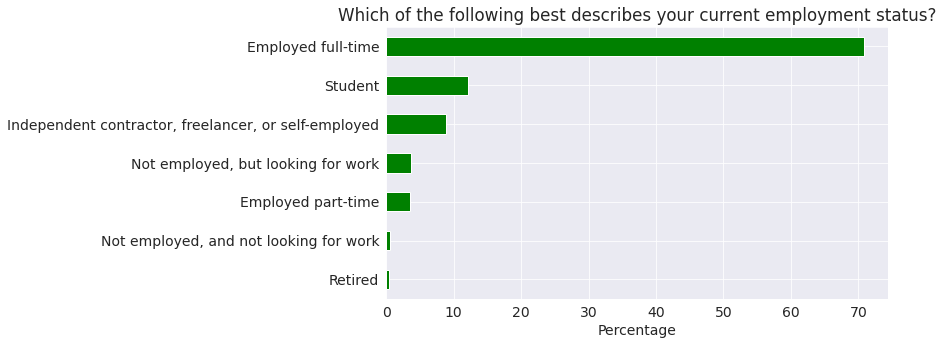

In [40]:
(survey_df.Employment.value_counts(normalize=True, ascending=True)*100).plot(kind='barh', color='g')
plt.title(schema.Employment)
plt.xlabel('Percentage');

It appears that close to 10% of respondents are employed part time or as freelancers.

**Exercise**: Add a new column `EmploymentType` containing the values `Enthusiast` (student or not employed but looking for work), `Professional` (employed full-time, part-time or freelancing), and `Other` (not employed or retired). For each of the graphs that follow, show a comparison between `Enthusiast` and `Professional`.



The `DevType` field contains information about the roles held by respondents. Since the question allows multiple answers, the column contains lists of values separated by a semi-colon `;`, making it a bit harder to analyze directly.

In [41]:
schema.DevType

'Which of the following describe you? Please select all that apply.'

In [42]:
survey_df.DevType.value_counts()

Developer, full-stack                                                                                                                                                                                                                                                                                                                  4396
Developer, back-end                                                                                                                                                                                                                                                                                                                    3056
Developer, back-end;Developer, front-end;Developer, full-stack                                                                                                                                                                                                                                                                         2214
Deve

Let's define a helper function that turns a column containing lists of values (like `survey_df.DevType`) into a data frame with one column for each possible option.

In [43]:
def split_multicolumn(col_series):
    result_df = col_series.to_frame()
    options = []
    # Iterate over the column
    for idx, value  in col_series[col_series.notnull()].iteritems():
        # Break each value into list of options
        for option in value.split(';'):
            # Add the option as a column to result
            if not option in result_df.columns:
                options.append(option)
                result_df[option] = False
            # Mark the value in the option column as True
            result_df.at[idx, option] = True
    return result_df[options]

In [44]:
dev_type_df = split_multicolumn(survey_df.DevType)

In [45]:
dev_type_df

,"Developer, desktop or enterprise applications","Developer, full-stack","Developer, mobile",Designer,"Developer, front-end","Developer, back-end","Developer, QA or test",DevOps specialist,"Developer, game or graphics",Database administrator,"Developer, embedded applications or devices","Engineer, data",Educator,System administrator,Engineering manager,Product manager,Data or business analyst,Academic researcher,Data scientist or machine learning specialist,Scientist,Senior executive/VP,"Engineer, site reliability",Marketing or sales professional
0,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64456,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
64457,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
64458,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
64459,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


The `dev_type_df` has one column for each option that can be selected as a response. If a respondent has chosen an option, the corresponding column's value is `True`. Otherwise, it is `False`.

We can now use the column-wise totals to identify the most common roles.


In [46]:
dev_type_totals = dev_type_df.sum().sort_values(ascending=False)
dev_type_totals

Developer, back-end                              26996
Developer, full-stack                            26915
Developer, front-end                             18128
Developer, desktop or enterprise applications    11687
Developer, mobile                                 9406
DevOps specialist                                 5915
Database administrator                            5658
Designer                                          5262
System administrator                              5185
Developer, embedded applications or devices       4701
Data or business analyst                          3970
Data scientist or machine learning specialist     3939
Developer, QA or test                             3893
Engineer, data                                    3700
Academic researcher                               3502
Educator                                          2895
Developer, game or graphics                       2751
Engineering manager                               2699
Product ma

As one might expect, the most common roles include "Developer" in the name. 

**Exercises**: 

* Can you figure out what percentage of respondents work in roles related to data science? 
* Which positions have the highest percentage of women?

We've only explored a handful of columns from the 20 columns that we selected. Explore and visualize the remaining columns using the empty cells below.

## Asking and Answering Questions

We've already gained several insights about the respondents and the programming community by exploring individual columns of the dataset. Let's ask some specific questions and try to answer them using data frame operations and visualizations.

#### Q: What are the most popular programming languages in 2020? 

To answer, this we can use the `LanguageWorkedWith` column. Similar to `DevType`, respondents were allowed to choose multiple options here.

In [47]:
survey_df.LanguageWorkedWith

0                                   C#;HTML/CSS;JavaScript
1                                         JavaScript;Swift
2                                 Objective-C;Python;Swift
3                                                      NaN
4                                        HTML/CSS;Ruby;SQL
                               ...                        
64456                                                  NaN
64457    Assembly;Bash/Shell/PowerShell;C;C#;C++;Dart;G...
64458                                                  NaN
64459                                             HTML/CSS
64460                      C#;HTML/CSS;Java;JavaScript;SQL
Name: LanguageWorkedWith, Length: 64306, dtype: object

First, we'll split this column into a data frame containing a column of each language listed in the options.

In [48]:
languages_worked_df = split_multicolumn(survey_df.LanguageWorkedWith)

In [49]:
languages_worked_df

,C#,HTML/CSS,JavaScript,Swift,Objective-C,Python,Ruby,SQL,Java,PHP,C,TypeScript,Bash/Shell/PowerShell,Kotlin,R,VBA,Perl,Scala,C++,Go,Haskell,Rust,Dart,Julia,Assembly
0,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,True,False,False,False,False,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64456,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
64457,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True
64458,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
64459,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


It appears that a total of 25 languages were included among the options. Let's aggregate these to identify the percentage of respondents who selected each language.


In [50]:
languages_worked_percentages = languages_worked_df.mean().sort_values(ascending=False) * 100
languages_worked_percentages

JavaScript               59.893323
HTML/CSS                 55.801947
SQL                      48.444935
Python                   39.001026
Java                     35.618760
Bash/Shell/PowerShell    29.239884
C#                       27.803004
PHP                      23.130035
TypeScript               22.461357
C++                      21.114670
C                        19.236152
Go                        7.758219
Kotlin                    6.887382
Ruby                      6.229590
Assembly                  5.447392
VBA                       5.394520
Swift                     5.226573
R                         5.064846
Rust                      4.498803
Objective-C               3.603085
Dart                      3.517557
Scala                     3.150561
Perl                      2.757130
Haskell                   1.861413
Julia                     0.782198
dtype: float64

We can plot this information using a horizontal bar chart.

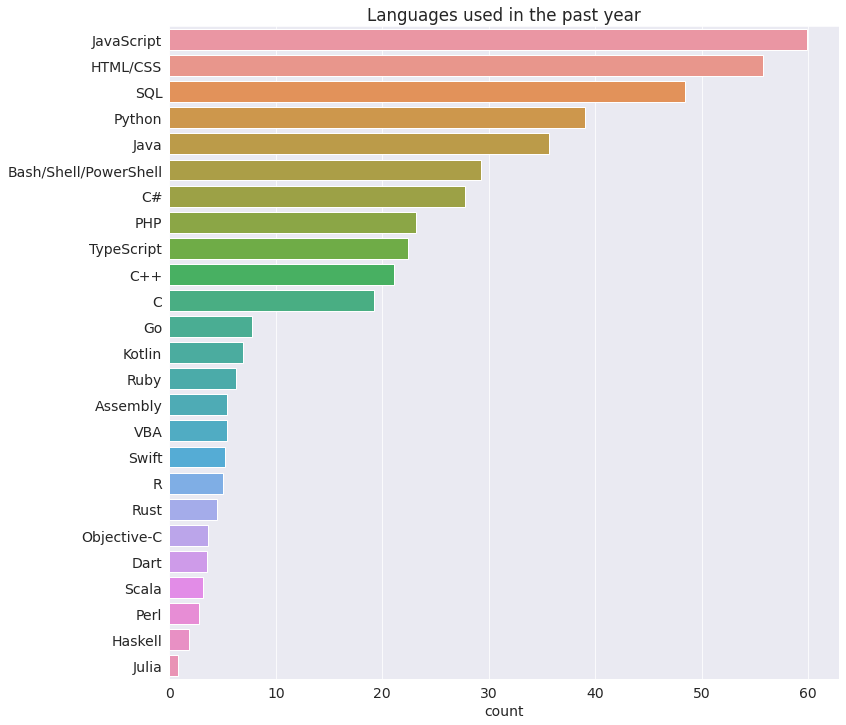

In [51]:
plt.figure(figsize=(12, 12))
sns.barplot(x=languages_worked_percentages, y=languages_worked_percentages.index)
plt.title("Languages used in the past year");
plt.xlabel('count');

Perhaps unsurprisingly, Javascript & HTML/CSS comes out at the top as web development is one of today's most sought skills. It also happens to be one of the easiest to get started. SQL is necessary for working with relational databases, so it's no surprise that most programmers work with SQL regularly. Python seems to be the popular choice for other forms of development, beating out Java, which was the industry standard for server & application development for over two decades.

**Exercises**:

* What are the most common languages used by students? How does the list compare with the most common languages used by professional developers?
* What are the most common languages among respondents who do not describe themselves as "Developer, front-end"?
* What are the most common languages among respondents who work in fields related to data science?
* What are the most common languages used by developers older than 35 years of age? 
* What are the most common languages used by developers in your home country?

#### Q: Which languages are the most people interested to learn over the next year?

For this, we can use the `LanguageDesireNextYear` column, with similar processing as the previous one.

In [52]:
languages_interested_df = split_multicolumn(survey_df.LanguageDesireNextYear)
languages_interested_percentages = languages_interested_df.mean().sort_values(ascending=False) * 100
languages_interested_percentages

Python                   41.143906
JavaScript               40.425466
HTML/CSS                 32.028116
SQL                      30.799614
TypeScript               26.451653
C#                       21.058688
Java                     20.464653
Go                       19.432090
Bash/Shell/PowerShell    18.057413
Rust                     16.270643
C++                      15.014151
Kotlin                   14.760676
PHP                      10.947657
C                         9.359935
Swift                     8.692812
Dart                      7.308805
R                         6.571704
Ruby                      6.425528
Scala                     5.326097
Haskell                   4.593662
Assembly                  3.766367
Julia                     2.540976
Objective-C               2.338818
Perl                      1.761888
VBA                       1.611047
dtype: float64

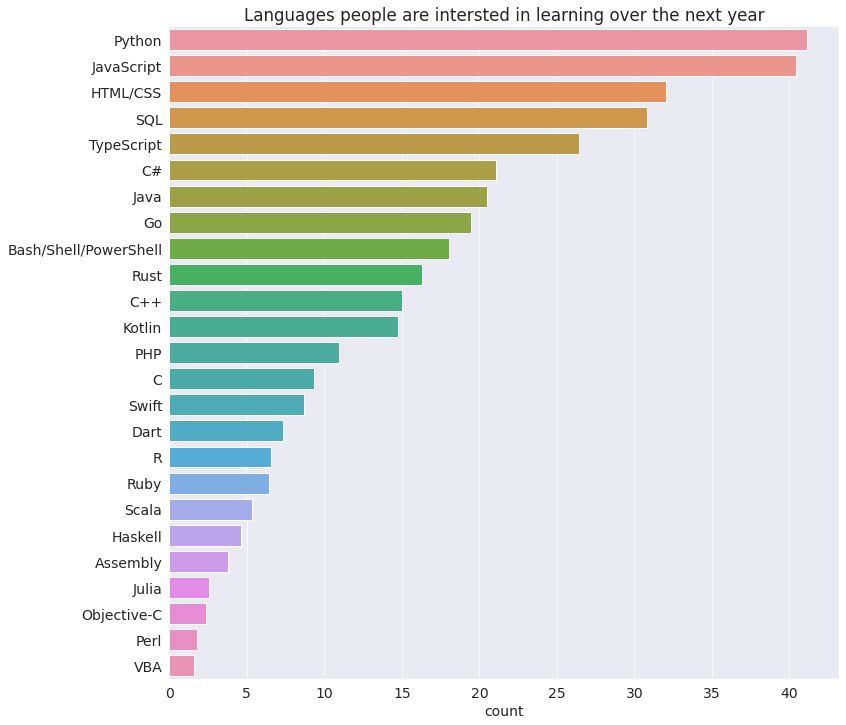

In [53]:
plt.figure(figsize=(12, 12))
sns.barplot(x=languages_interested_percentages, y=languages_interested_percentages.index)
plt.title("Languages people are intersted in learning over the next year");
plt.xlabel('count');

Once again, it's not surprising that Python is the language most people are interested in learning - since it is an easy-to-learn general-purpose programming language well suited for a variety of domains: application development, numerical computing, data analysis, machine learning, big data, cloud automation, web scraping, scripting, etc. We're using Python for this very analysis, so we're in good company!

**Exercises**: Repeat the exercises from the previous question, replacing "most common languages" with "languages people are interested in learning/using."

#### Q:  Which are the most loved languages, i.e., a high percentage of people who have used the language want to continue learning & using it over the next year?

While this question may seem tricky at first, it's straightforward to solve using Pandas array operations. Here's what we can do:

- Create a new data frame `languages_loved_df` that contains a `True` value for a language only if the corresponding values in `languages_worked_df` and `languages_interested_df` are both `True`
- Take the column-wise sum of `languages_loved_df` and divide it by the column-wise sum of `languages_worked_df` to get the percentage of respondents who "love" the language
- Sort the results in decreasing order and plot a horizontal bar graph

In [54]:
languages_loved_df = languages_worked_df & languages_interested_df

In [55]:
languages_loved_percentages = (languages_loved_df.sum() * 100/ languages_worked_df.sum()).sort_values(ascending=False)

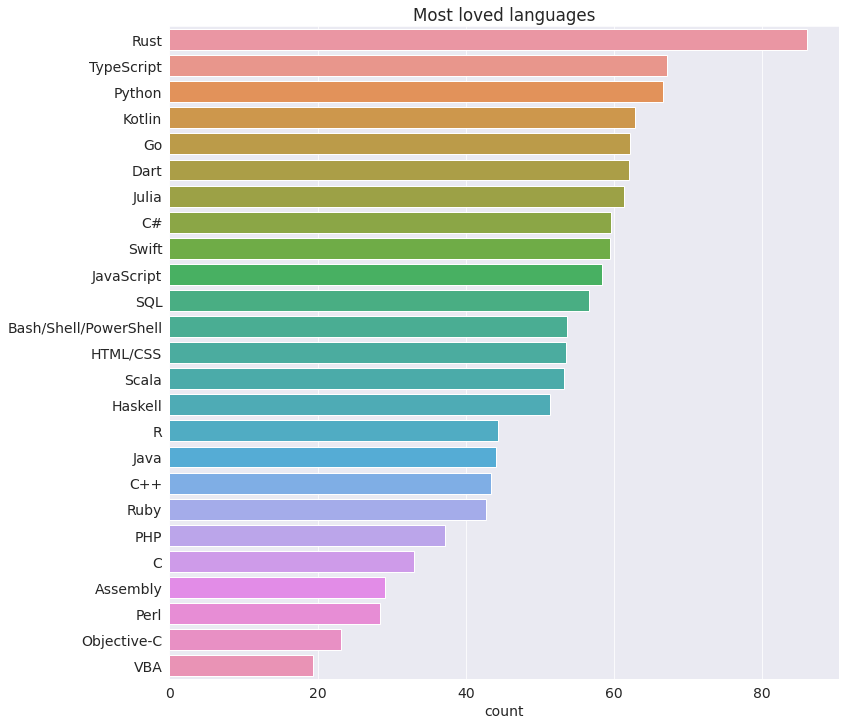

In [56]:
plt.figure(figsize=(12, 12))
sns.barplot(x=languages_loved_percentages, y=languages_loved_percentages.index)
plt.title("Most loved languages");
plt.xlabel('count');

[Rust](https://www.rust-lang.org) has been StackOverflow's most-loved language for [four years in a row](https://stackoverflow.blog/2020/01/20/what-is-rust-and-why-is-it-so-popular/). The second most-loved language is TypeScript, a popular alternative to JavaScript for web development.

Python features at number 3, despite already being one of the most widely-used languages in the world. Python has a solid foundation, is easy to learn & use, has a large ecosystem of domain-specific libraries, and a massive worldwide community.

**Exercises:** What are the most dreaded languages, i.e., languages which people have used in the past year but do not want to learn/use over the next year. Hint: `~languages_interested_df`.

#### Q: In which countries do developers work the highest number of hours per week? Consider countries with more than 250 responses only.

To answer this question, we'll need to use the `groupby` data frame method to aggregate the rows for each country. We'll also need to filter the results to only include the countries with more than 250 respondents.

In [57]:
countries_df = survey_df.groupby('Country')[['WorkWeekHrs']].mean().sort_values('WorkWeekHrs', ascending=False)

In [58]:
high_response_countries_df = countries_df.loc[survey_df.Country.value_counts() > 250].head(15)

In [59]:
high_response_countries_df

,WorkWeekHrs
Country,
Iran,44.337748
Israel,43.915094
China,42.150000
United States,41.802982
Greece,41.402724
Viet Nam,41.391667
South Africa,41.023460
Turkey,40.982143
Sri Lanka,40.612245


The Asian countries like Iran, China, and Israel have the highest working hours, followed by the United States. However, there isn't too much variation overall, and the average working hours seem to be around 40 hours per week.

**Exercises:**

* How do the average work hours compare across continents? You may find this list of [countries in each continent](https://hub.jovian.ml/wp-content/uploads/2020/09/countries.csv) useful.
* Which role has the highest average number of hours worked per week? Which one has the lowest?
* How do the hours worked compare between freelancers and developers working full-time?

#### Q: How important is it to start young to build a career in programming?

Let's create a scatter plot of `Age` vs. `YearsCodePro` (i.e., years of coding experience) to answer this question.

In [60]:
schema.YearsCodePro

'NOT including education, how many years have you coded professionally (as a part of your work)?'

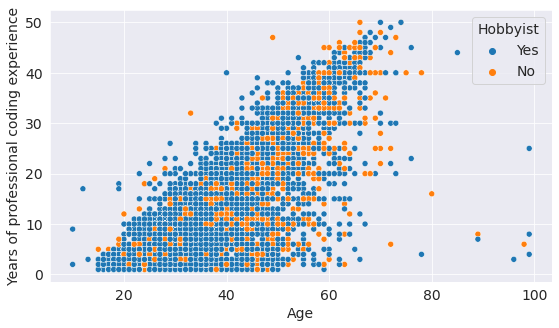

In [61]:
sns.scatterplot(x='Age', y='YearsCodePro', hue='Hobbyist', data=survey_df)
plt.xlabel("Age")
plt.ylabel("Years of professional coding experience");

You can see points all over the graph, which indicates that you can **start programming professionally at any age**. Many people who have been coding for several decades professionally also seem to enjoy it as a hobby.

We can also view the distribution of the `Age1stCode` column to see when the respondents tried programming for the first time.

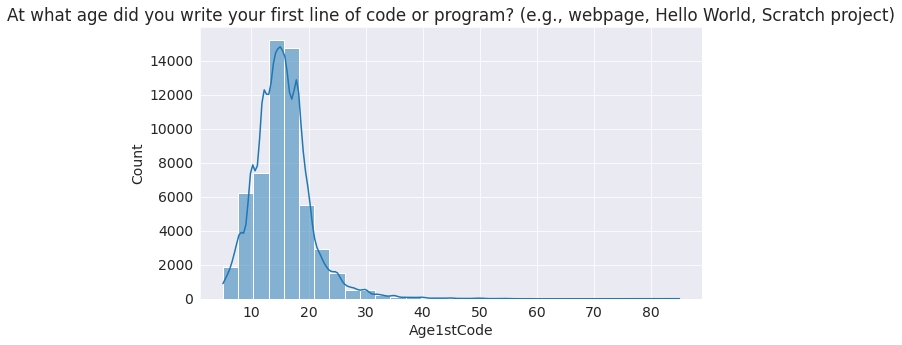

In [62]:
plt.title(schema.Age1stCode)
sns.histplot(x=survey_df.Age1stCode, bins=30, kde=True);

As you might expect, most people seem to have had some exposure to programming before the age of 40. However, but there are people of all ages and walks of life learning to code.

**Exercises**:

* How does programming experience change opinions & preferences? Repeat the entire analysis while comparing the responses of people who have more than ten years of professional programming experience vs. those who don't. Do you see any interesting trends?
* Compare the years of professional coding experience across different genders. 


Hopefully, you are already thinking of many more questions you'd like to answer using this data. Use the empty cells below to ask and answer more questions.

## Inferences and Conclusions

We've drawn many inferences from the survey. Here's a summary of a few of them:

- Based on the survey respondents' demographics, we can infer that the survey is somewhat representative of the overall programming community. However, it has fewer responses from programmers in non-English-speaking countries and women & non-binary genders.

- The programming community is not as diverse as it can be. Although things are improving, we should make more efforts to support & encourage underrepresented communities, whether in terms of age, country, race, gender, or otherwise.


- Although most programmers hold a college degree, a reasonably large percentage did not have computer science as their college major. Hence, a computer science degree isn't compulsory for learning to code or building a career in programming.

- A significant percentage of programmers either work part-time or as freelancers, which can be a great way to break into the field, especially when you're just getting started.

- Javascript & HTML/CSS are the most used programming languages in 2020, closely followed by SQL & Python.

- Python is the language most people are interested in learning - since it is an easy-to-learn general-purpose programming language well suited for various domains.

- Rust and TypeScript are the most "loved" languages in 2020, both of which have small but fast-growing communities. Python is a close third, despite already being a widely used language.

- Programmers worldwide seem to be working for around 40 hours a week on average, with slight variations by country.

- You can learn and start programming professionally at any age. You're likely to have a long and fulfilling career if you also enjoy programming as a hobby.


## Exercises

There's a wealth of information to be discovered using the survey, and we've barely scratched the surface. Here are some ideas for further exploration:

- Repeat the analysis for different age groups & genders, and compare the results
- Pick a different set of columns (we chose 20 out of 65) to analyze other facets of the data
- Prepare an analysis focusing on diversity - and identify areas where underrepresented communities are at par with the majority (e.g., education) and where they aren't (e.g., salaries)
- Compare the results of this year's survey with the previous years and identify interesting trends


## References and Future Work

Check out the following resources to learn more about the dataset and tools used in this notebook:

- Stack Overflow Developer Survey: https://insights.stackoverflow.com/survey
- Pandas user guide: https://pandas.pydata.org/docs/user_guide/index.html
- Matplotlib user guide: https://matplotlib.org/3.3.1/users/index.html
- Seaborn user guide & tutorial: https://seaborn.pydata.org/tutorial.html
- `opendatasets` Python library: https://github.com/JovianML/opendatasets